<a href="https://colab.research.google.com/github/SCBonds/sweetpea-py/blob/Spencer_Branch/SweetPea_Tutorial_Stroop_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Design Experiments

## Example: Stroop Task

In previous sections we described the Stroop task (Stroop, 1935) in which participants are typically asked to name the color in which a color word is displayed (e.g., say ``green'' to the word <font color="green">RED</font> displayed in green). Here, we consider the Stroop color naming experiment with the two regular factors described above: the color factor representing the color in which the stimulus is displayed, and having four levels:  red, green, blue, brown; and the word factor representing the word itself, also having four levels corresponding to each of the colors (see Figure below). On a given trial, one level from each factor is used to generate the stimulus, and the participant is required to respond to the color factor, indicating the color in which the word was displayed. For instance, they may be required to press the left arrow key if the word was displayed in red, the right arrow key if it was in green, the up arrow key if it was in blue, the down arrow if it was in brown.  This results in a response factor with four levels: left, right, up and down. 

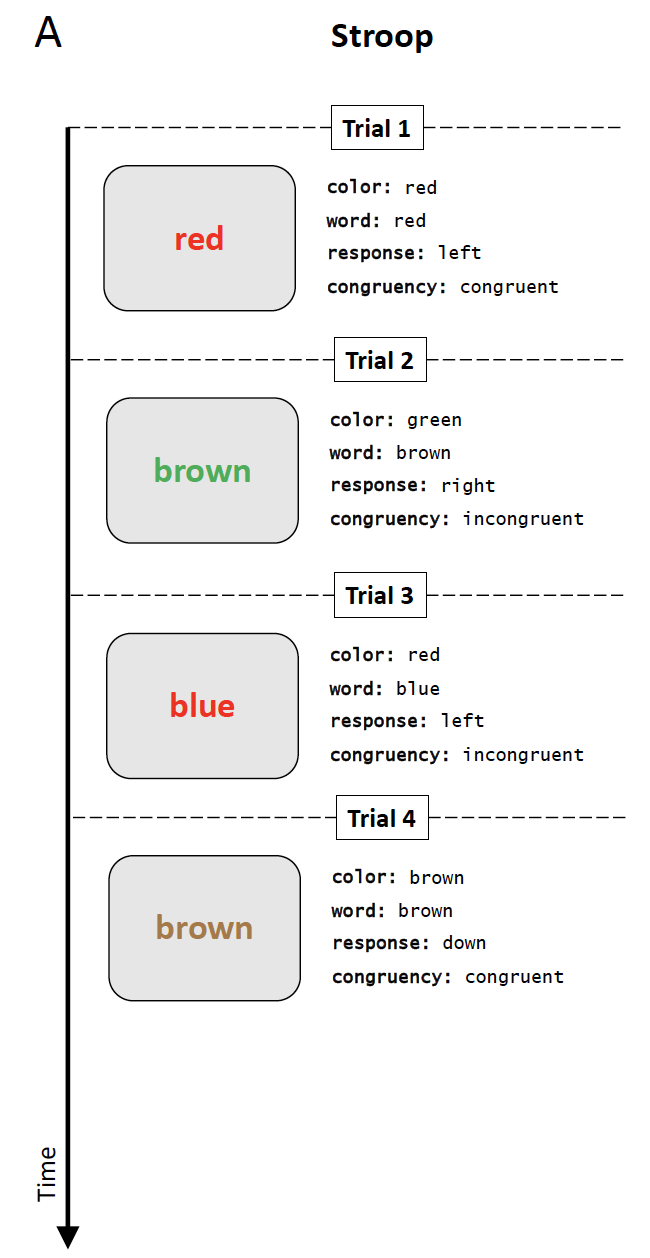

In the general case, an experimenter may want to ensure that each color is paired with each word. This could be achieved by crossing all colors with all words. The full crossing of colors and words includes conditions in which the color and the word are the same (congruent; e.g., the word <font color="red">RED</font> displayed in red), as well as conditions in which they are different (incongruent; e.g., the written word <font color="red">GREEN</font> displayed in red). Together, the two conditions define the congruency of a trial. In this particular experiment, we wish to pair each color with each word, subject to the constraint that only incongruent trials are included. Finally, we wish to generate a minimum of 20 experiment trials. For the ease of the reader, we interleave each chunk of code with an explanation of what it does for the first walkthrough example. 

### Importing Modules

We begin with installing SweetPea and the relevant modules:

In [ ]:
# code to prevent installation outputs

%%capture

# install and import modules

!pip install sweetpea

from sweetpea.primitives import Factor, DerivedLevel, WithinTrial
from sweetpea.constraints import MinimumTrials, Exclude
from sweetpea import fully_cross_block, synthesize_trials_non_uniform, print_experiments, tabulate_experiments, experiment_to_csv

Modules in line 3 are needed to specify regular and derived factors. Modules in line 4 are required to implement design constraints, such as specification of the minimum number of trials and the exclusion of factor levels. The modules imported in line 5 serve to generate, sample, print, tabulate and export the final experiment. 

We continue with defining the two basic factors, $\texttt{color}$ and $\texttt{word}$:

In [ ]:
# color and word factors

color = Factor(name="color", initial_levels=["red", "green", "blue", "brown"])
word = Factor(name="word", initial_levels=["red", "green", "blue", "brown"])

as well as the $\texttt{response}$ factor:

In [ ]:
# response factor

def is_response_left(color):
    return color == "red"
def is_response_right(color):
    return color == "green"
def is_response_up(color):
    return color == "blue"
def is_response_down(color):
    return color == "brown"

response = Factor(name="response", initial_levels=[
    DerivedLevel(name="left", window=WithinTrial(predicate=is_response_left, factors=[color])),
    DerivedLevel(name="right", window=WithinTrial(predicate=is_response_right, factors=[color])),
    DerivedLevel(name="up", window=WithinTrial(predicate=is_response_up, factors=[color])),
    DerivedLevel(name="down", window=WithinTrial(predicate=is_response_down, factors=[color]))
])

Levels of the $\texttt{response}$ factor are dependent on the factor $\texttt{color}$. Each of its derived levels is defined by a predicate that takes as input the $\texttt{color}$ factor describing the current stimulus. For instance, the following function is used to define a leftward response:

```python
def is_response_left(color):
    return color == "red"
```

The function returns true if the factor $\texttt{color}$ on a given trial evaluates to the level “red”. The function is used to specify the derived level “left” in the definition of the factor $\texttt{response}$:

```python
DerivedLevel(name="left", window=WithinTrial(predicate=is_response_left, factors=[color]))
```

The first argument specifies the level name “left”. The second argument is the function $\texttt{WithinTrial}$, which passes the $\texttt{color}$ factor of the current trial to the $\texttt{is_response_left}$ predicate to determine whether the factor $\texttt{response}$ evaluates to the level “left”. 

The $\texttt{congruency}$ factor is defined in a similar fashion:

In [ ]:
# congruency factor

def is_congruent(color, word):
    return color == word

def is_incongruent(color, word):
    return not is_congruent(color, word)

congruent = DerivedLevel(name="congruent", window=WithinTrial(predicate=is_congruent, factors=[color, word]))
incongruent = DerivedLevel(name="incongruent", window=WithinTrial(predicate=is_incongruent, factors=[color, word]))

congruency = Factor(name="congruency", initial_levels=[congruent, incongruent])

Both levels of the $\texttt{congruency}$ factor are dependent on the $\texttt{color}$ and $\texttt{word}$ factors of the current trial. Thus, the predicates specifying these levels take the $\texttt{color}$ and the $\texttt{word}$ factors as arguments. For instance, a trial is considered congruent if the color and word of the current trial match:

```python
def is_congruent(color, word):
    return color == word
```

Note that the definition of the corresponding derived level must include $\texttt{WithinTrial}$, with both $\texttt{color}$ and $\texttt{word}$ as arguments:

```python
DerivedLevel(name="congruent", window=WithinTrial(predicate=is_congruent, factors=[color, word]))
```

The experiment code then specifies two constraints: $\texttt{MinimumTrials}$ and $\texttt{Exclude}$. 

$\texttt{MinimumTrials}$ indicates the minimum number of trials.

In [ ]:
# constraints

trial_constraint = MinimumTrials(trials=20)

In this example, the $\texttt{MinimumTrials}$ constraint ensures that the experiment sequence includes at least 20 trials. Note that a full crossing of all valid trials (without 4 possible congruent trials) requires a multiple of 4 x 4 - 4 = 12 trials. Thus, $\texttt{MinimumTrials}$ will not satisfy a full crossing unless the specified minimum number of trials is a multiple of 12. To mitigate this issue, ${SweetPea}$ successively samples trials without replacement from counterbalanced blocks. In this example, the first 12 trials are sampled from a block of 12 counterbalanced trials, and the remaining 8 trials  are sampled without replacement from another counterbalanced block. Note, the current version of ${SweetPea}$ only supports this counterbalancing scheme for experimental designs without transition factors and constraints. Future versions of ${SweetPea}$ will coordinate this counterbalancing scheme across multiple experiment sequences, e.g., to allow for the counterbalancing of remaining trials across participants (Latin square design).

The next constraint, $\texttt{Exclude}$, defines an exclusion criterion according to which the level $\texttt{congruent}$ of the factor $\texttt{congruency}$ is excluded from the experiment.

In [ ]:
exclusion_constraint = Exclude(factor=congruency, level=congruent)

All constraints to be included in the design are listed next.

In [ ]:
stroop_constraints = [trial_constraint, exclusion_constraint]

We continue with specifying the full experiment:

In [ ]:
# experiment

stroop_design     = [color, word, response, congruency]
stroop_crossing   = [color, word]
stroop_block      = fully_cross_block(design=stroop_design, crossing=stroop_crossing, constraints=stroop_constraints, require_complete_crossing=False)

The entire experimental design is defined by the factors $\texttt{color}$, $\texttt{word}$, $\texttt{response}$ and $\texttt{congruency}$. The crossing between all colors and all words is specified in the second code line above. The design, crossing and constraints are used to define a fully crossed experiment block (subject to said constraints). However, a complete crossing between all colors and words is not possible because we want to exclude all congruent trials for which the color and the word match. Thus, $\texttt{fully_cross_block}$ would return no solution to the experimental design unless we allow the crossing to be incomplete, by setting $\texttt{require_complete_crossing}$ to $\texttt{False}$. 

We can now generate, print, tabulate and save a desired sequence of trials:

In [ ]:
stroop_experiments = synthesize_trials_non_uniform(block=stroop_block, samples=1)

print_experiments(block=stroop_block, experiments=stroop_experiments)

tabulate_experiments(experiments=stroop_experiments, factors=stroop_crossing)

experiment_to_csv(experiments=stroop_experiments, file_prefix="experiment")

Sampling 1 trial sequences using the <class 'sweetpea.sampling_strategies.non_uniform.NonUniformSamplingStrategy'>
    /root/.local/share/SweetPea/Executables/unigen
    /root/.local/share/SweetPea/Executables/approxmc
    /root/.local/share/SweetPea/Executables/cryptominisat5
Done.
1 trial sequences found.
Experiment 0:
color brown | word green | response down  | congruency incongruent
color brown | word blue  | response down  | congruency incongruent
color blue  | word brown | response up    | congruency incongruent
color green | word blue  | response right | congruency incongruent
color red   | word brown | response left  | congruency incongruent
color blue  | word red   | response up    | congruency incongruent
color brown | word red   | response down  | congruency incongruent
color green | word brown | response right | congruency incongruent
color blue  | word brown | response up    | congruency incongruent
color brown | word red   | response down  | congruency incongruent
color r

The first line above specifies how the experiment should be generated:

```python
stroop_experiments = synthesize_trials_non_uniform(block=stroop_block, samples=1)
```

In this case, we sample the experiment block only once, thus the argument $\texttt{1}$. The function $\texttt{synthesize_trials_non_uniform}$ solves for experiment sequences without guaranteeing that they are sampled uniformly from the space of all possible solutions (see Section *Solving Experimental Designs*). 

We then print the experiment, yielding output like the following (illustrative first six lines are shown):

```python
1 trial sequences found.
Experiment 0:
color brown | word red   | response down  | congruency incongruent
color green | word red   | response right | congruency incongruent
color brown | word blue  | response down  | congruency incongruent
color red   | word blue  | response left  | congruency incongruent
```

To check the frequency of each factor combination, next we tabulate the generated experiment sequence for the factors specified in the crossing. The generated table lists the frequency and proportion of each factor level combination (illustrative first six lines of output are shown):

```python
Experiment 0:
color red   | word red   | frequency 0 | proportion 0.0% 
color red   | word green | frequency 2 | proportion 10.0%
color red   | word blue  | frequency 1 | proportion 5.0% 
color red   | word brown | frequency 2 | proportion 10.0%
color green | word red   | frequency 2 | proportion 10.0%
```

Finally, we export the generated experiment sequence to a CSV file named "experiment\_0.csv" in the local folder "path". Note, both the $\texttt{print_experiments}$ and the $\texttt{experiment_to_csv}$ functions require a list of experiments. Here, we want to generate just one experiment, so both functions will output one experiment sequence.

### Consolidated Example

Note, for completeness we have not included code to prevent the installation outputs as above.

In [ ]:
!pip install sweetpea

from sweetpea.primitives import Factor, DerivedLevel, WithinTrial
from sweetpea.constraints import MinimumTrials, Exclude
from sweetpea import fully_cross_block, synthesize_trials_non_uniform, print_experiments, tabulate_experiments, experiment_to_csv

# color and word factors

color = Factor(name="color", initial_levels=["red", "green", "blue", "brown"])
word = Factor(name="word", initial_levels=["red", "green", "blue", "brown"])

# response factor

def is_response_left(color):
    return color == "red"
def is_response_right(color):
    return color == "green"
def is_response_up(color):
    return color == "blue"
def is_response_down(color):
    return color == "brown"

response = Factor(name="response", initial_levels=[
    DerivedLevel(name="left", window=WithinTrial(predicate=is_response_left, factors=[color])),
    DerivedLevel(name="right", window=WithinTrial(predicate=is_response_right, factors=[color])),
    DerivedLevel(name="up", window=WithinTrial(predicate=is_response_up, factors=[color])),
    DerivedLevel(name="down", window=WithinTrial(predicate=is_response_down, factors=[color]))
])

# congruency factor

def is_congruent(color, word):
    return color == word

def is_incongruent(color, word):
    return not is_congruent(color, word)

congruent = DerivedLevel(name="congruent", window=WithinTrial(predicate=is_congruent, factors=[color, word]))
incongruent = DerivedLevel(name="incongruent", window=WithinTrial(predicate=is_incongruent, factors=[color, word]))

congruency = Factor(name="congruency", initial_levels=[congruent, incongruent])

# constraints

trial_constraint = MinimumTrials(trials=20)
exclusion_constraint = Exclude(factor=congruency, level=congruent)

stroop_constraints = [trial_constraint, exclusion_constraint]

# experiment

stroop_design     = [color, word, response, congruency]
stroop_crossing   = [color, word]
stroop_block      = fully_cross_block(design=stroop_design, crossing=stroop_crossing, constraints=stroop_constraints, require_complete_crossing=False)

stroop_experiments = synthesize_trials_non_uniform(block=stroop_block, samples=1)

print_experiments(block=stroop_block, experiments=stroop_experiments)

tabulate_experiments(experiments=stroop_experiments, factors=stroop_crossing)

experiment_to_csv(experiments=stroop_experiments, file_prefix="experiment")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Sampling 1 trial sequences using the <class 'sweetpea.sampling_strategies.non_uniform.NonUniformSamplingStrategy'>
1 trial sequences found.
Experiment 0:
color brown | word green | response down  | congruency incongruent
color brown | word blue  | response down  | congruency incongruent
color blue  | word brown | response up    | congruency incongruent
color green | word blue  | response right | congruency incongruent
color red   | word brown | response left  | congruency incongruent
color blue  | word red   | response up    | congruency incongruent
color brown | word red   | response down  | congruency incongruent
color green | word brown | response right | congruency incongruent
color blue  | word brown | response up    | congruency incongruent
color brown | word red   | response down  | congruency incongruent
color red   | word green | response left  | congruency incongruent
color brow